In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import random
from collections import Counter

# $d_f$ and $\tau$ for SC

**The idea:** Calculate the Fisher exponent $\tau$ and the fractal dimension of the incipient infinite cluster $d_f$ in the Ising-percolation model on the Sierpinski carpet. For this, it is important to take into account that

\begin{align}
M_*= L^{d_f}
\end{align}

where $M_*$ is the mass of the incipient infinite cluster and $L$ the size of the lattice; and

\begin{align}
n_s \propto s^{-\tau}
\end{align}

where $n_s$ is the number of clusters with size $s$.

In [2]:
def sierpinski_carpet(mask, total): #total number of times the process will be repeated  
    for i in range(0, total + 1):
        stepdown = 3**(total - i)
        for x in range(0, 3**i):
          
            # checking for the centremost square
            if x % 3 == 1:
                for y in range(0, 3**i):
                    if y % 3 == 1:
                      
                    # changing its value
                        mask[y * stepdown:(y + 1)*stepdown, x * stepdown:(x + 1)*stepdown] = 0
                        
    return mask

In [3]:
def flattice(times):
    
    N= 3**times
    lattice= np.random.choice([-1, 1], size=(N, N))
    flattice= sierpinski_carpet(lattice, times)
    
    return flattice

In [4]:
def calculate_energy(lattice, i, j):
    size = lattice.shape[0]
    
    spin_ij = lattice[i, j]

    neighbors_indices = [((i+1) % size, j), ((i-1+size) % size, j), (i, (j+1) % size), (i, (j-1+size) % size)]


    dE = 0

    for ni, nj in neighbors_indices:
        if 0 <= ni < size and 0 <= nj < size:
            spin_neighbor = lattice[ni, nj]
            dE += 2 * spin_ij * spin_neighbor

    return dE

In [5]:
def metropolis_step(lattice, temperature):
    
    size = lattice.shape[0]
    i, j = random.randint(0, size-1), random.randint(0, size-1)
    
    beta= 1/temperature
    while lattice[i,j] == 0:
        i, j = random.randint(0, size-1), random.randint(0, size-1)
        
    dE = calculate_energy(lattice, i, j)
    
    if (dE > 0) and (np.random.random() < np.exp(-dE*beta)):
        lattice[i, j] *= -1
    elif dE <= 0:
        lattice[i, j] *= -1

In [6]:
def swendsen_wang_step(lattice, times, temperature, r_clusters):
    
    size = lattice.shape[0]
    
    visited = np.full_like(lattice, -1)
    
    visited = sierpinski_carpet(visited, times)
    
        
    clusters = []
    
    # Calculate bond probability based on temperature and coupling constant J
    p = 1.0 - np.exp(-2 /  (temperature))

    for i in range(size):
        for j in range(size):
            if visited[i, j] == -1:
                cluster = set()
                stack = [(i, j)]

                while stack:
                    x, y = stack.pop()
                    if visited[x, y] == -1:
                        visited[x, y] = 1
                        cluster.add((x, y))
                        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                            nx, ny = x + dx, y + dy  # Removed modulo operations for no-periodic boundary conditions
                            if 0 <= nx < size and 0 <= ny < size:  # Check for valid indices within the lattice
                                if visited[nx, ny] == -1 and lattice[x, y] == lattice[nx, ny] and np.random.rand() < p:
                                    stack.append((nx, ny))

                clusters.append(cluster)
    
    for cluster in clusters:
        if random.random() < 0.5:
            for i, j in cluster:
                lattice[i, j] *= -1
                
    if r_clusters == True:  
        return clusters

In [7]:
def combined_metropolis_swendsen_wang(lattice, temperature, times,  m, n):
    for _ in range(m):
        metropolis_step(lattice, temperature)
    for _ in range(n): 
        swendsen_wang_step(lattice, times, temperature, False)

## 1. $d_f$ calculation

**Steps:**
1. Choose different sizes for $L$, in our case $L=(3^4, 3^5, 3^6, 3^7)$.
2. For each lattice of size $L$, run $m$ iterations of the Metropolis algorithm and $n$ iterations of the Swendsen-Wang algorithm to reach equilibrium at the critical temperature ($T_c= 1.48$).
3. In the final step of the Swendsen-Wang algorithm, save the size of the largest cluster $M_*$.
4. Repeat this process 5 times and compute the average of $M_*$ for a more precise prediction.
5. Plot $log(\bar{M_*})$ as a function of $log(L)$ and find the slope. This will correspond to $d_f$.

Approximate computation time: 5 hours.

In [8]:
def size_infinite_cluster(lattice, times, TJ):
    m= 1000000
    n=200
    size_clusters= []
    combined_metropolis_swendsen_wang(lattice, TJ, times, m, n)
    clusters= swendsen_wang_step(lattice, times, TJ, True)
    size_clusters.extend([len(cluster) for cluster in clusters])
    cluster_max= max(size_clusters)          
    return cluster_max

In [9]:
sizes=[3,4,5,6,7]
m_len_cluster=[]
std_len_cluster=[]
for i in tqdm (range(len(sizes))):
    len_cluster=[]
    for k in range(15):
        lattice= flattice(sizes[i])
        size= size_infinite_cluster(lattice, sizes[i], 1.48)
        len_cluster.append(size)
    m_len_cluster.append(np.mean(len_cluster))
    std_len_cluster.append(np.std(len_cluster))

100%|██████████| 5/5 [11:23:15<00:00, 8199.06s/it] 


In [10]:
L=[3**3, 3**4, 3**5, 3**6, 3**7]
x= np.log(L)
x=np.array(x).reshape(-1,1)
y= np.log(m_len_cluster)

model = LinearRegression()
model.fit(x, y)
coefficients = model.coef_
print("Coefficient:", coefficients[0])

predicted_y = model.predict(x)

Coefficient: 1.7245667330254297


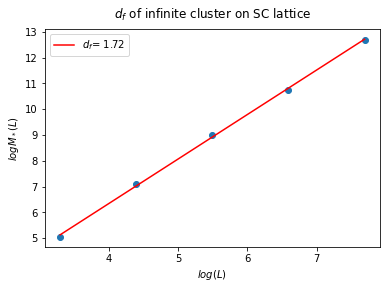

In [11]:
plt.scatter(x, y)
label= fr'$d_f$= {coefficients[0]:.2f}'
plt.plot(x, predicted_y, c="red", label=label)
plt.title(r"$d_f$ of infinite cluster on SC lattice", y=1.02)
plt.xlabel(r"$log(L)$")
plt.ylabel(r"$log M_*(L)$")
plt.legend()

## 2. $\tau$ calculation

**Steps:**
1. Choose a size  $L$ for the lattice, in our case $L= 3^6$.
2. Run $m$ iterations of the Metropolis algorithm and $n$ iterations of the Swendsen-Wang algorithm to reach equilibrium at the critical temperature ($T_c= 1.48$).
3. In the final step of the Swendsen-Wang algorithm, save the size of all the clusters.
4. Count the frequency ($n_s$) of different cluster sizes ($s$).
5. Plot $log(n_s)$ as a function of $log(s)$ and find the slope. This will correspond to $\tau$.

Approximate computation time: 4 minutes.

In [12]:
def cluster_distribution(lattice, times, TJ):
    m= 1000000
    n= 200
    size_clusters= []
    combined_metropolis_swendsen_wang(lattice, TJ, times, m, n)
    clusters= swendsen_wang_step(lattice, times, TJ, True)
    size_clusters.extend([(len(cluster)) for cluster in clusters])
    return size_clusters

In [13]:
sc_=[]

lattice= flattice(6)
sc= cluster_distribution(lattice, 6, 1.48)

#sc_.append(sc)
#sc_m=np.mean(np.array(sc_), axis=0)
#sc_s= np.std(np.array(sc_), axis=0)


In [14]:
count = Counter(sc)
numbers, frequencies = zip(*count.items())
x2= np.log(numbers)
y2= np.log(frequencies)


l= 3.0
y1=[yi for yi in y2 if yi > l]
selected_indices = [index for index, value in enumerate(y2) if value > l]
x1= [x2[index] for index in selected_indices]
x1= np.array(x1).reshape(-1,1)

In [15]:
model2 = LinearRegression()
model2.fit(x1, y1)
coefficients2 = model2.coef_

predicted_y2 = model2.predict(x1)

print("Coefficient:", coefficients2[0])

Coefficient: -2.0774309951418717


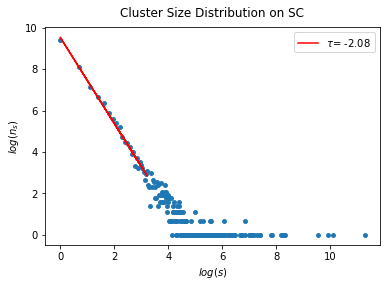

In [16]:
plt.scatter(x2, y2, marker='o', s=15)
plt.xlabel(r'$log(s)$')
plt.ylabel(r'$log(n_s)$')
label= fr'$\tau$= {coefficients2[0]:.2f}'
plt.plot(x1, predicted_y2, c="red", label=label)
plt.legend()
plt.title("Cluster Size Distribution on SC", y=1.02)



# Show the plot
plt.show()